# Szeregi czasowe - sieci neuronowe

Zwykle do modelowania szeregów czasowych używa się prostych modeli liniowych takich jak AR, MA, ARMA lub ARIMA. Czasami jednak możemy potrzebować bardziej ekspresyjnego modelu, który będzie w stanie się wyuczyć złożonych zależności temporalnych pomiędzy obserwacjami. W takiej sytuacji możemy wykorzystać sieci neuronowe.

Uczenie głębokie z powodzeniem wykorzystywane jest do różnych zadań w obszarze przetwarzania języka naturalnego lub obrazów. Możemy je również wykorzystać do modelowania i predykcji szeregów czasowych. Poniżej przedstawiono, w jaki sposób można do tego celu wykorzystać perceptron, rekurencyjne sieci neuronowe (RNN) oraz LSTM.

Tutorial jest przygotowany w języku R z wykorzystaniem biblioteki Keras. Biblioteka ta do prawidłowego działania wymaga dodatkowo zainstalowanego Pythona wraz z TensorFlow.

UWAGA: Niniejszy tutorial ma na celu pokazanie wykorzystania sieci neuronowych w obszarze szeregów czassowych i zakłada, że czytający ma podstawową wiedzę z zakresu uczenia głębokiego (MLP, RNN, LSTM, problem seq2seq).

## Zbiór danych
W prezentowanych przykładach wykorzystamy zbiór zawierający miesięczną liczbę pasażerów amerykańskich linii lotniczych w latach 1949-1960. Szereg zawiera łącznie 144 obserwacje.

### Wczytanie zioru

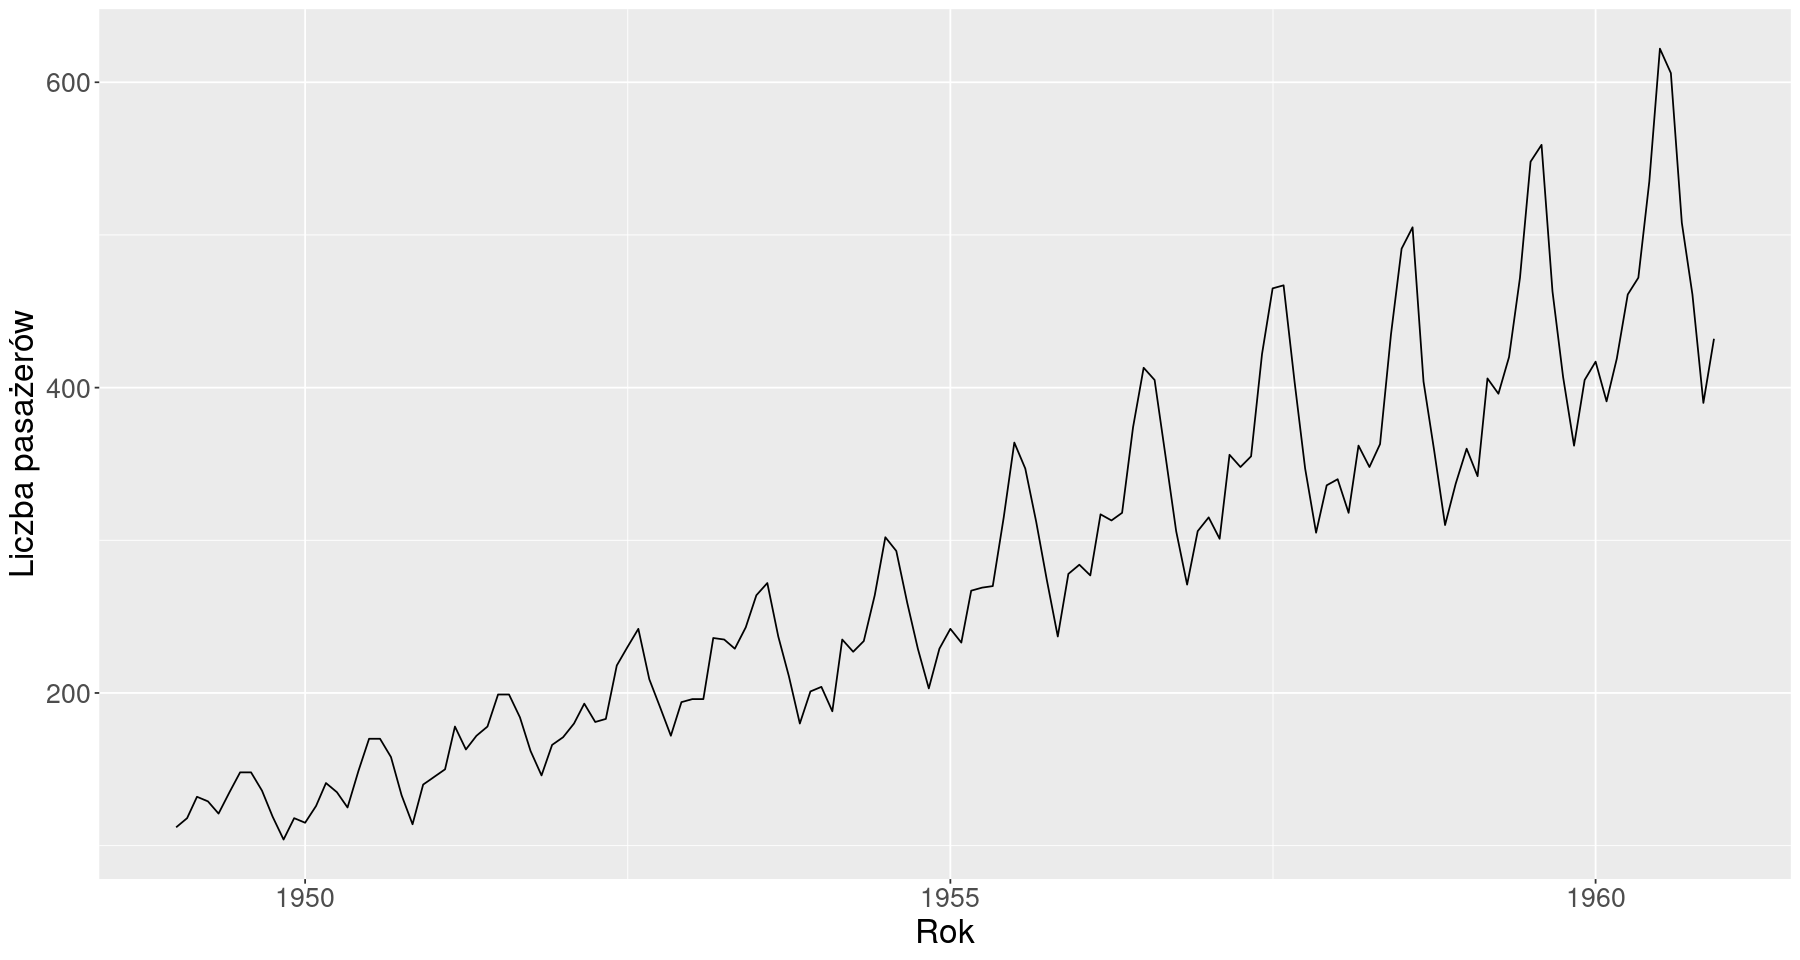

In [1]:
library(anytime) 
suppressPackageStartupMessages(library(tidyverse))
suppressPackageStartupMessages(library(forecast))

# wczytanie
data <- read.csv('data/AirPassengers.csv', header=TRUE, stringsAsFactors=FALSE)

# konwersja stringa na date
data$month <- anydate(data$month)

# czyszczenie danych
data$passengers = tsclean(data$passengers)

# wizualizacja szeregu
options(repr.plot.width=15, repr.plot.height=8)
ggplot(data, aes(month, passengers)) + 
    geom_line() + xlab("Rok") + 
    ylab("Liczba pasażerów") + 
    theme(text = element_text(size = 20))          

### Normalizacja

In [2]:
normalize <- function(x) {
    min_x <- min(x)
    max_x <- max(x)
    return(list(data = (x - min_x) / (max_x - min_x), min = min_x, max = max_x))
}

denormalize <- function(x, min_x, max_x) {
    return(x * (max_x - min_x) + min_x)
}

norm_data <- normalize(data$passengers)
data$passengers <- norm_data$data
min_x <- norm_data$min
max_x <- norm_data$max

### Podział danych na zbiór treningowy i testowy

In [3]:
data_train <- data[1:120, 'passengers']
data_test <- data[121:144, 'passengers']

## Predykcja jednego kroku
Na początek zajmijmy się najprostszym przypadkiem, czyli wykorzystaniem sieci neuronowej do predykcji tylko jednej przyszłej obserwacji. 

Zostaną zaprezentowane następujące modele:
- perceptron (MLP)
- RNN
- LSTM

### Przygotowanie danych
Pierwszym krokiem będzie przygotowanie danych do takiej postaci, żeby mogły zostać przetworzone przez sieć neuronową.

Zazwyczaj mamy do dyspozycji wiele obserwacji posiadających różne cechy, jednak w przypadku szeregów czasowych dysponujemy tylko serią pojedynczych obserwacji. Rozwiązaniem tego problemu jest podzielenie naszego szeregu na wiele miniszeregów o długości $L$. Na potrzeby tego ćwiczenia przyjmiemy $L=5$, jednakże należy pamiętać, że w rzeczywistości wybór wartości $L$ powinien być oparty o zbiór walidacyjny. 

Dane wejściowe i wyjściowe powinny zostać doprowadzone do następującej postaci:
$$
X = \begin{bmatrix}
v_{1} & v_{2} & v_{3} & v_{4} & v_{5}\\
v_{2} & v_{3} & v_{4} & v_{5} & v_{6}\\
v_{3} & v_{4} & v_{5} & v_{6} & v_{7}\\
... & ... & ... & ... & ...
\end{bmatrix} \qquad Y = \begin{bmatrix}
v_{6} \\
v_{7} \\
v_{8} \\
... 
\end{bmatrix}
$$

Algorytmy takie jak RNN i LSTM oczekują danych trójwymiarowych, dlatego musimy dodatkowo przekształcić powyższe dane dwuwymiarowe do postaci (*n_seq, L, n_feat*) gdzie:
- *n_seq* to liczba minisekwencji.
- *L* to długość pojedynczej minisekwencji. W naszym przypadku $L=5$.
- *n_feat* to liczba cech pojedynczej obserwacji. W naszym przypadku będzie to tylko liczba pasażerów, ale nic nie stoi na przeszkodzie, żeby zastosować więcej cech.

In [4]:
split_sequence <- function(data, x_len, y_len) {
    max_len <- x_len + y_len
    
    data_matrix <- matrix(0, nrow = length(data) - max_len + 1, ncol = max_len) 

    for(i in 1:(nrow(data_matrix))){
        data_matrix[i,] <- data[i:(i + max_len - 1)]
    }

    x <- data_matrix[, -((ncol(data_matrix) - y_len + 1):ncol(data_matrix))]
    y <- data_matrix[, (ncol(data_matrix) - y_len + 1):ncol(data_matrix)]

    x <- array(x, c(nrow(x), x_len, 1))
    
    return(list(x = x, y = y))
}

splited_seq <- split_sequence(data_train, x_len = 5, y_len = 1)

x_train <- splited_seq$x
y_train <- splited_seq$y

splited_seq <- split_sequence(data_test, x_len = 5, y_len = 1)

x_test <- splited_seq$x
y_test <- splited_seq$y

### Perceptron
Perceptron to najprostsza sieć neuronowa, która składa się tylko z jednego neuronu. Dla przyjętego parametru $L=5$ model ten jest tożsamy z modelem AR(5). Dodając warstwę ukrytą otrzymamy perceptron wielowarstwowy. Dzięki tej dodatkowej warstwie model stanie się nieliniowy.

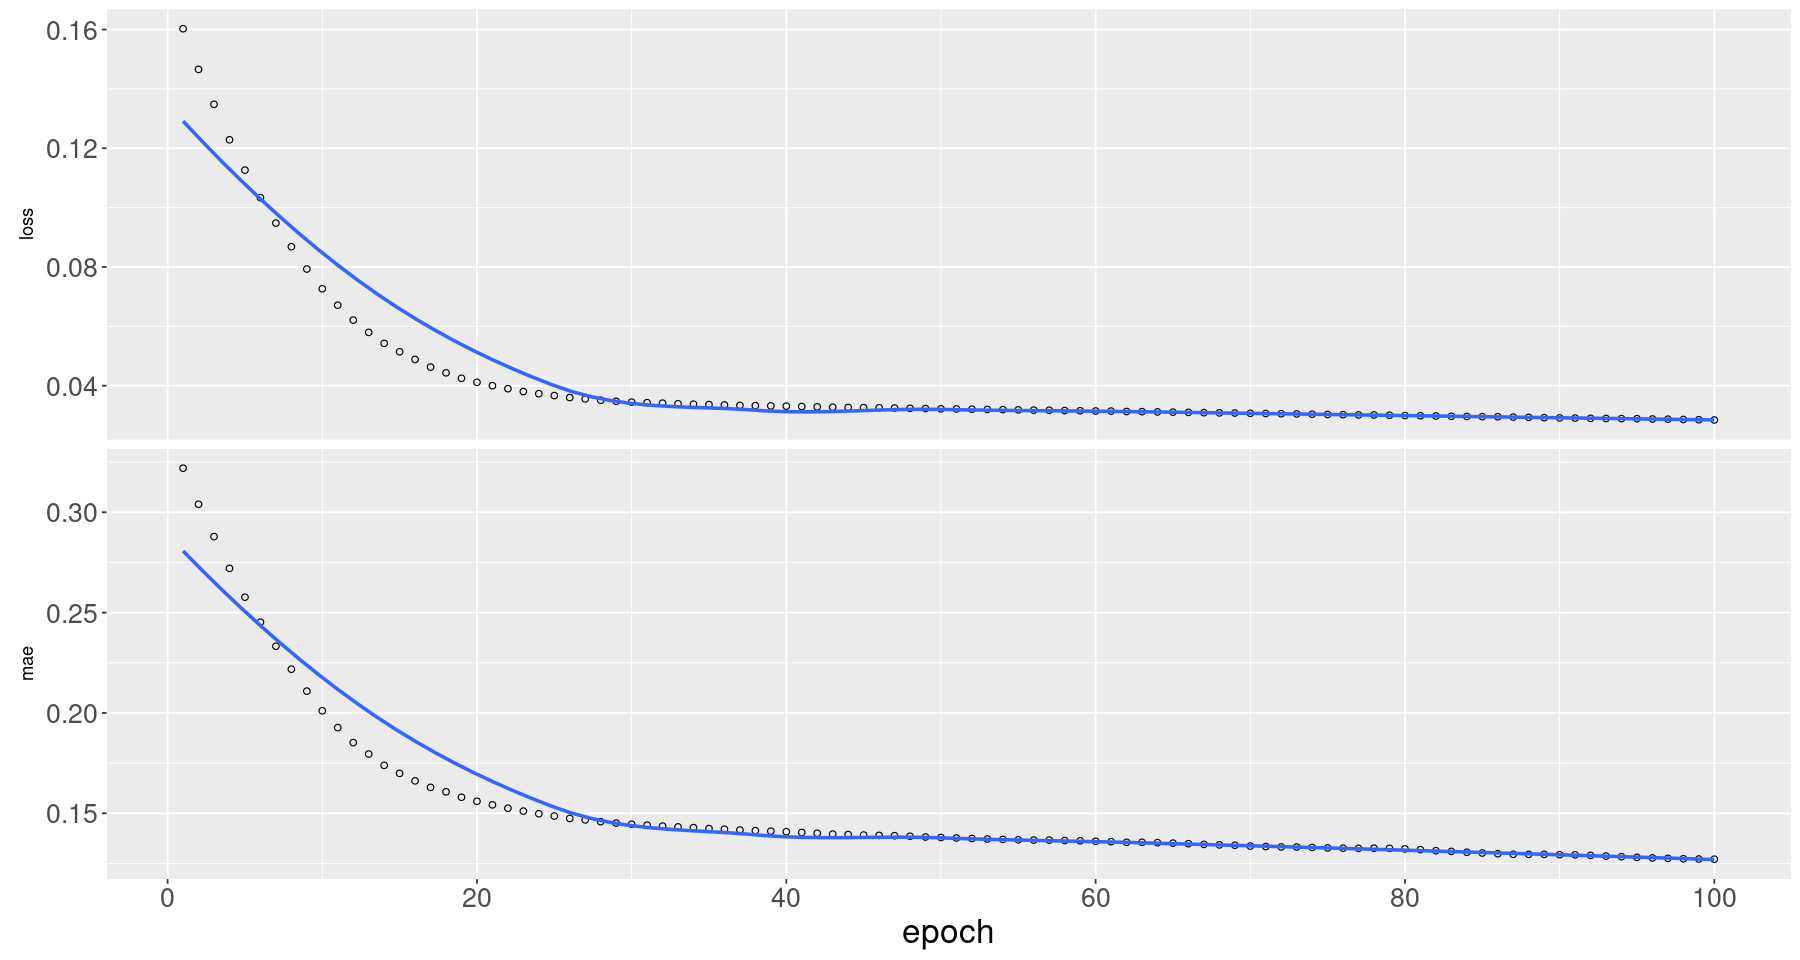

In [5]:
suppressPackageStartupMessages(library(keras))
library(tensorflow)

set_random_seed(1)

model <- keras_model_sequential()
model %>%
  layer_flatten(input_shape = dim(x_train)[-1])%>%
#   dodatkowa warstwa wprowadzająca nieliniowość
#   layer_dense(units = 50) %>%
  layer_dense(units = 1)

model %>% compile(
  loss = "mse",
  optimizer= 'adam',
  metric = "mae" 
)

history <- model %>% 
 fit(x_train, y_train, epochs = 100, batch_size = 16, verbose = 2)

plot(history) + theme(text = element_text(size = 20))

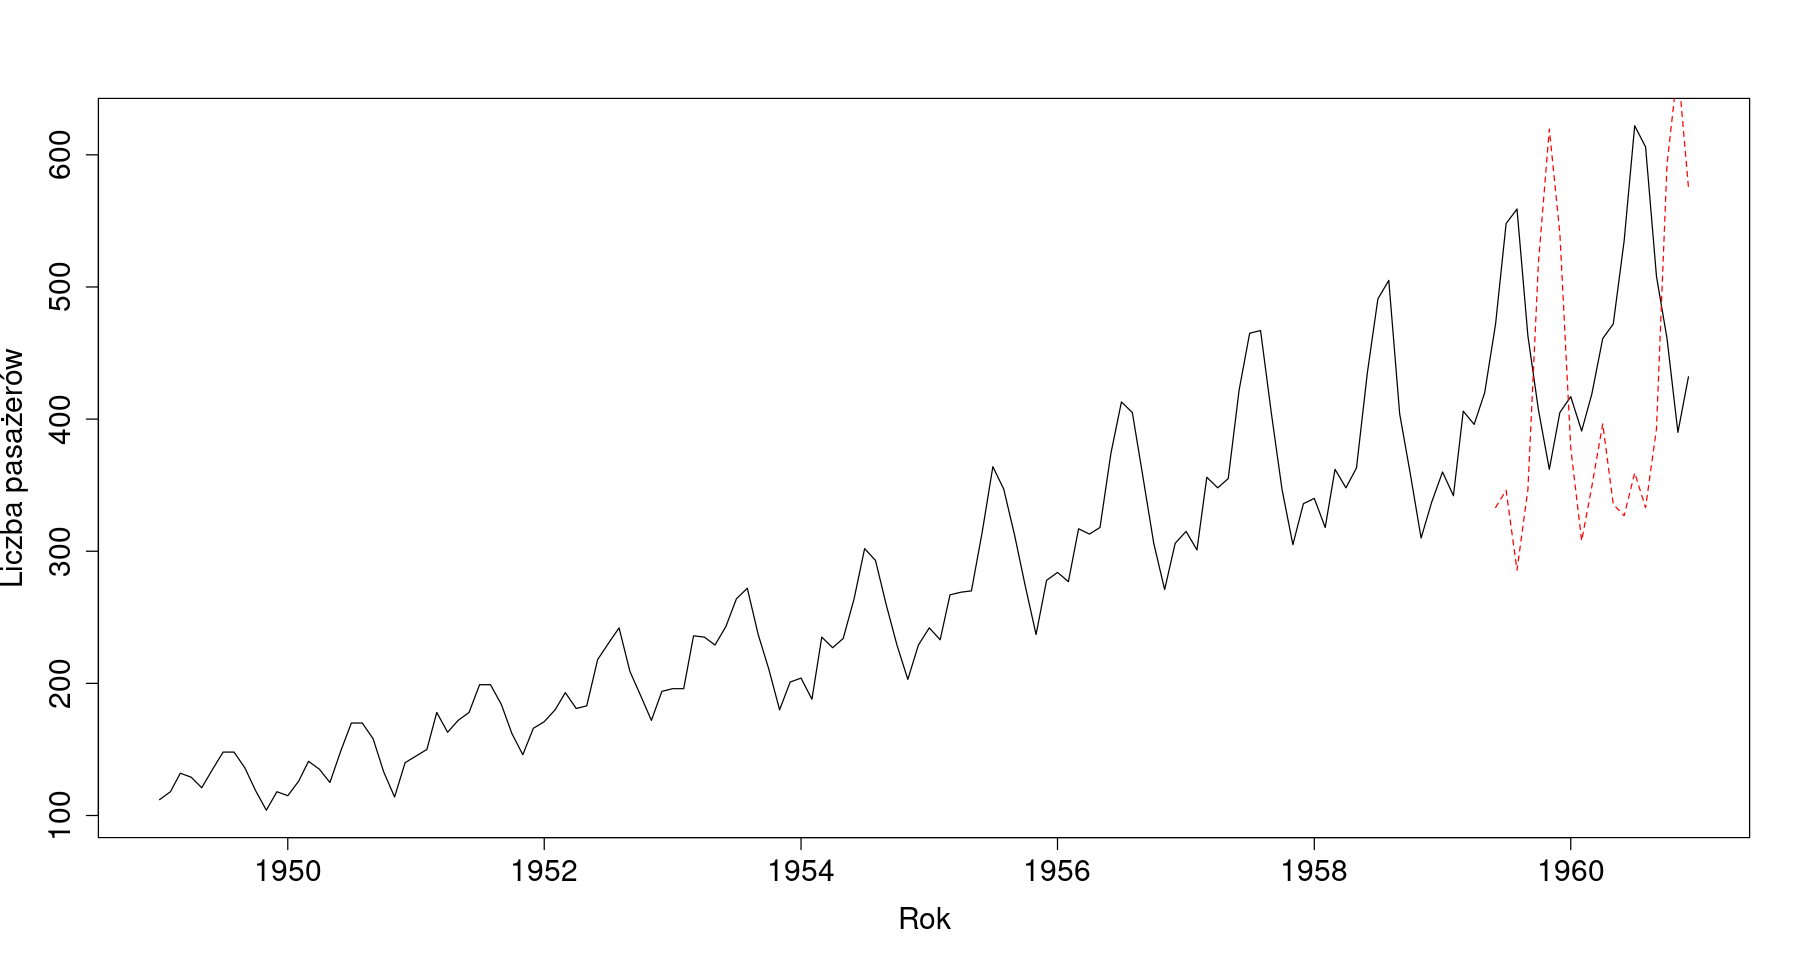

In [6]:
pred_nn <- model %>% predict(x_test)

plot(x=data$month, y=denormalize(data$passengers, min_x, max_x), type="l", col='black', 
     xlab="Rok", ylab="Liczba pasażerów", cex.lab=1.5, cex.axis=1.5, cex.main=1.5, cex.sub=1.5)

lines(data[(nrow(data) - length(y_test)+1):nrow(data),'month'], 
      y=denormalize(pred_nn, min_x, max_x), lty=2, col='red')

### RNN

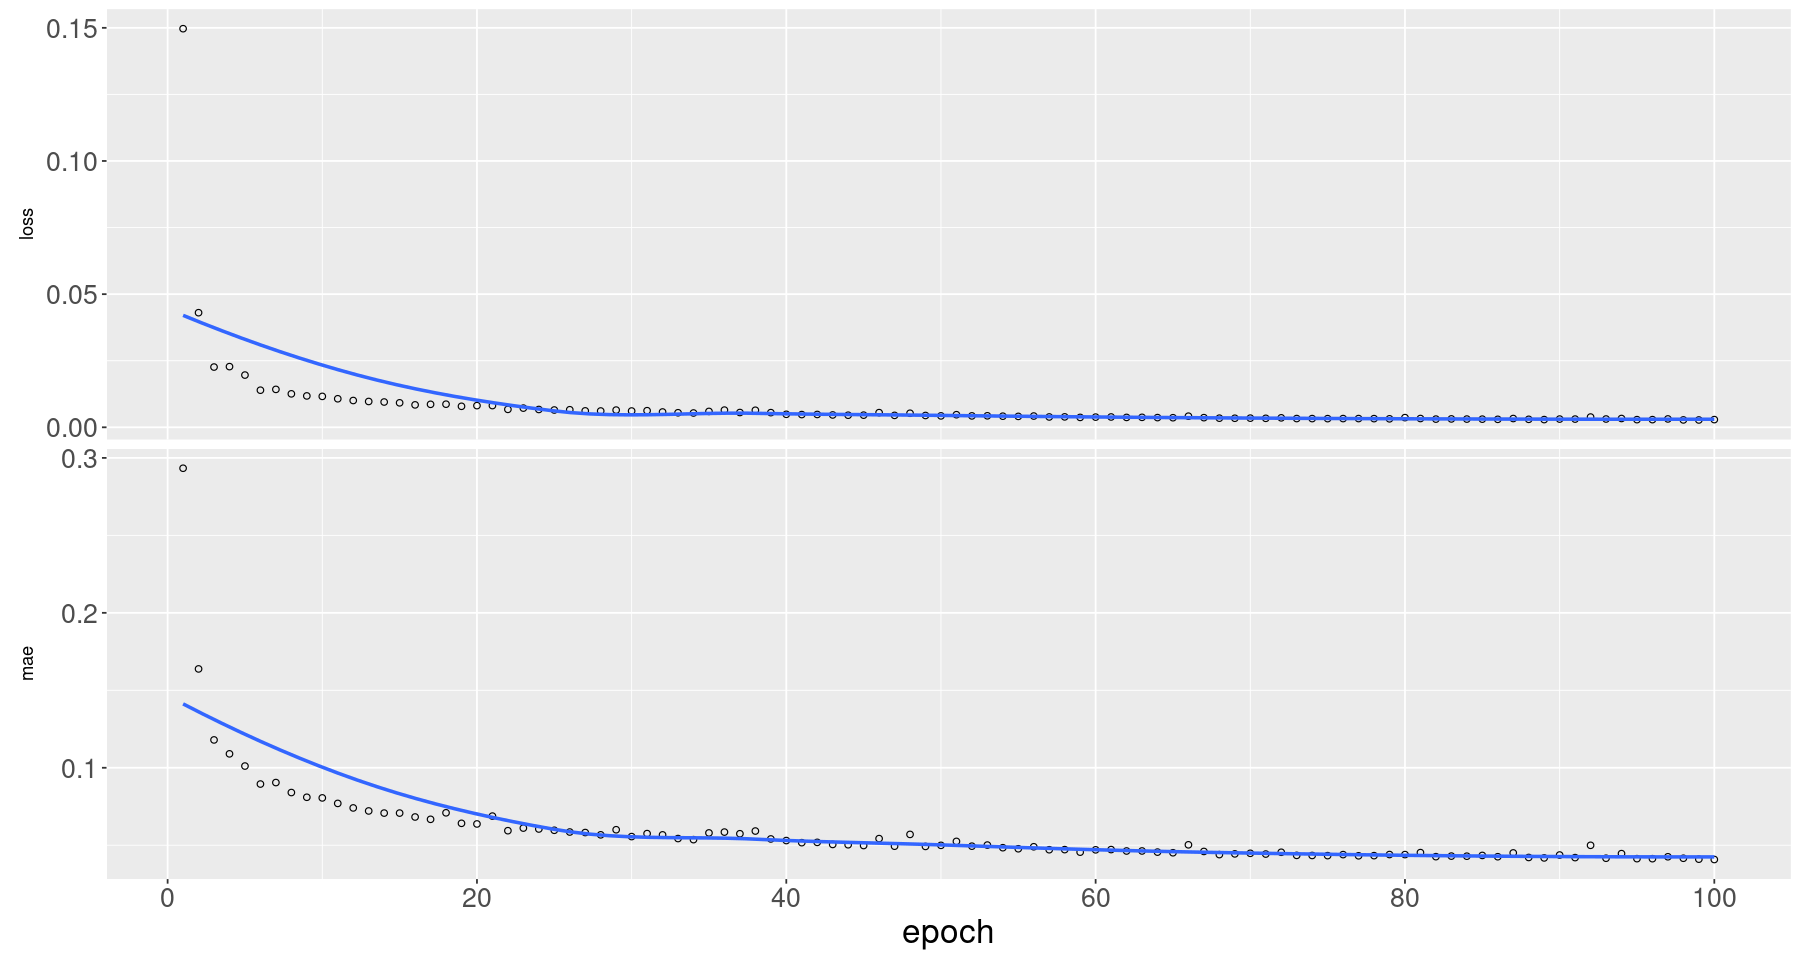

In [7]:
model <- keras_model_sequential()
model %>%
  layer_simple_rnn(units = 50, input_shape = dim(x_train)[-1]) %>%
  layer_dense(units = 1)

model %>% compile(
  loss = "mse",
  optimizer= 'adam',
  metric = "mae" 
)

history <- model %>% 
 fit(x_train, y_train, epochs = 100, batch_size = 16, verbose = 2)

plot(history) + theme(text = element_text(size = 20)) 

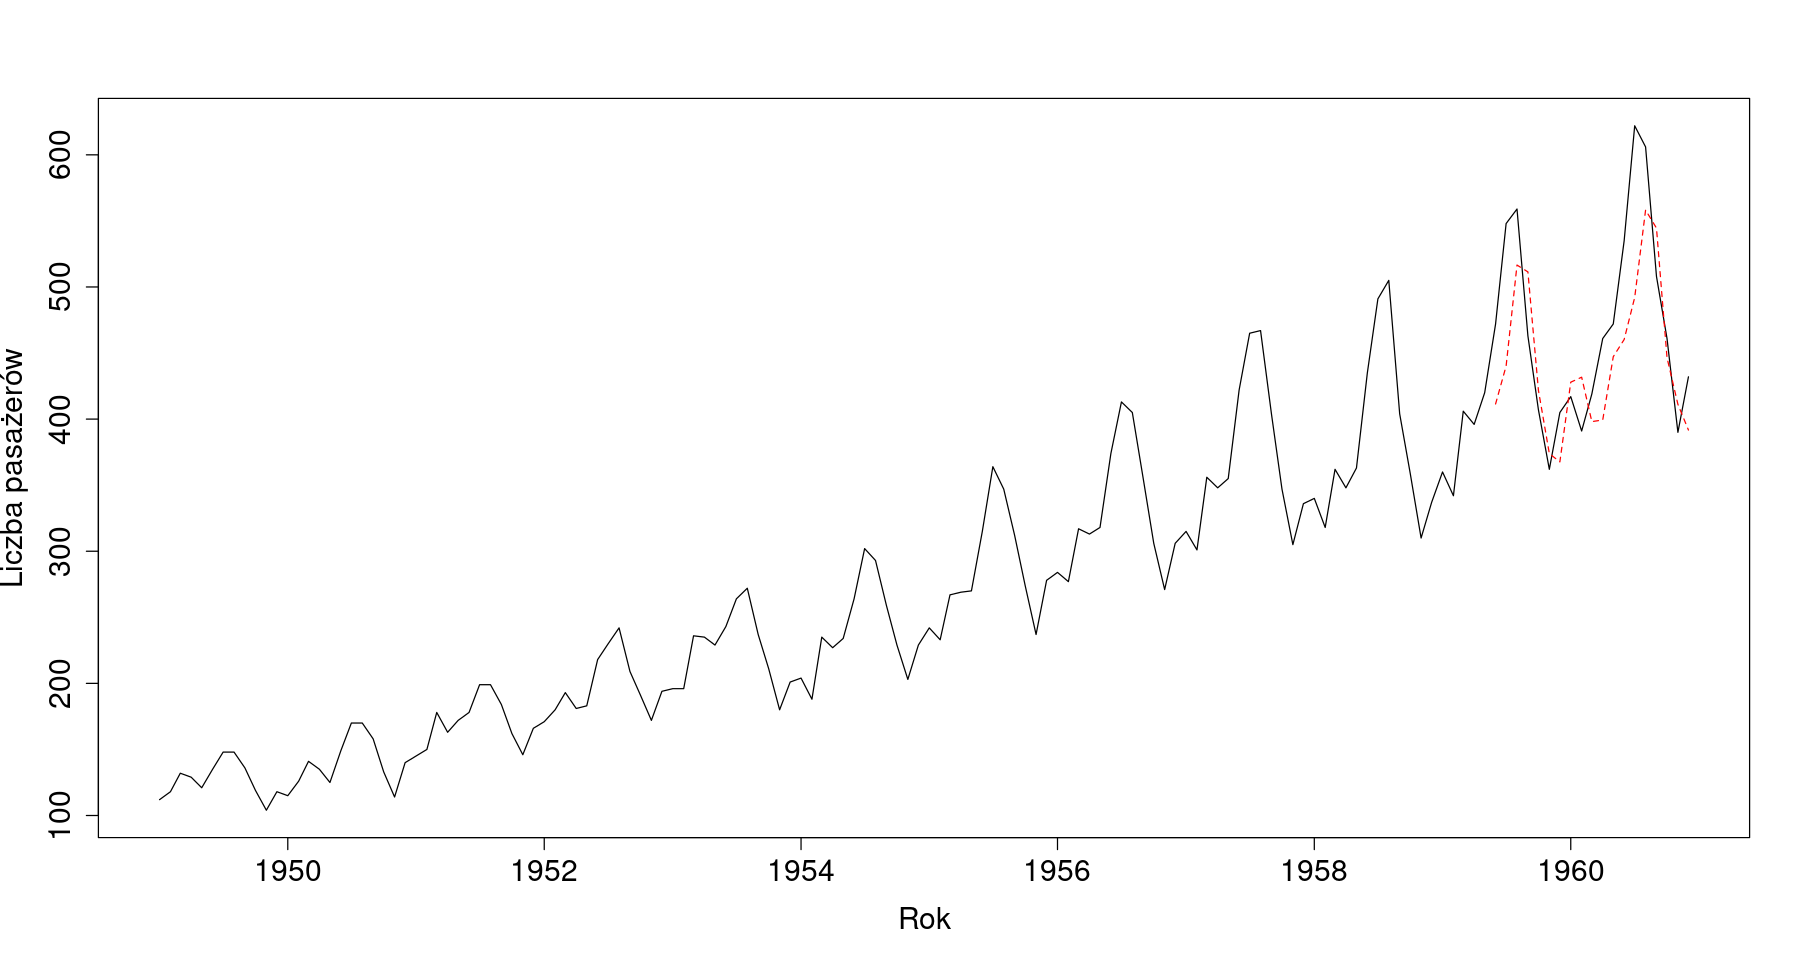

In [8]:
pred_rnn <- model %>% predict(x_test)

plot(x=data$month, y=denormalize(data$passengers, min_x, max_x), type="l", col='black', 
     xlab="Rok", ylab="Liczba pasażerów", cex.lab=1.5, cex.axis=1.5, cex.main=1.5, cex.sub=1.5)

lines(data[(nrow(data) - length(y_test)+1):nrow(data),'month'], 
      y=denormalize(pred_rnn, min_x, max_x), lty=2, col='red')

### LSTM

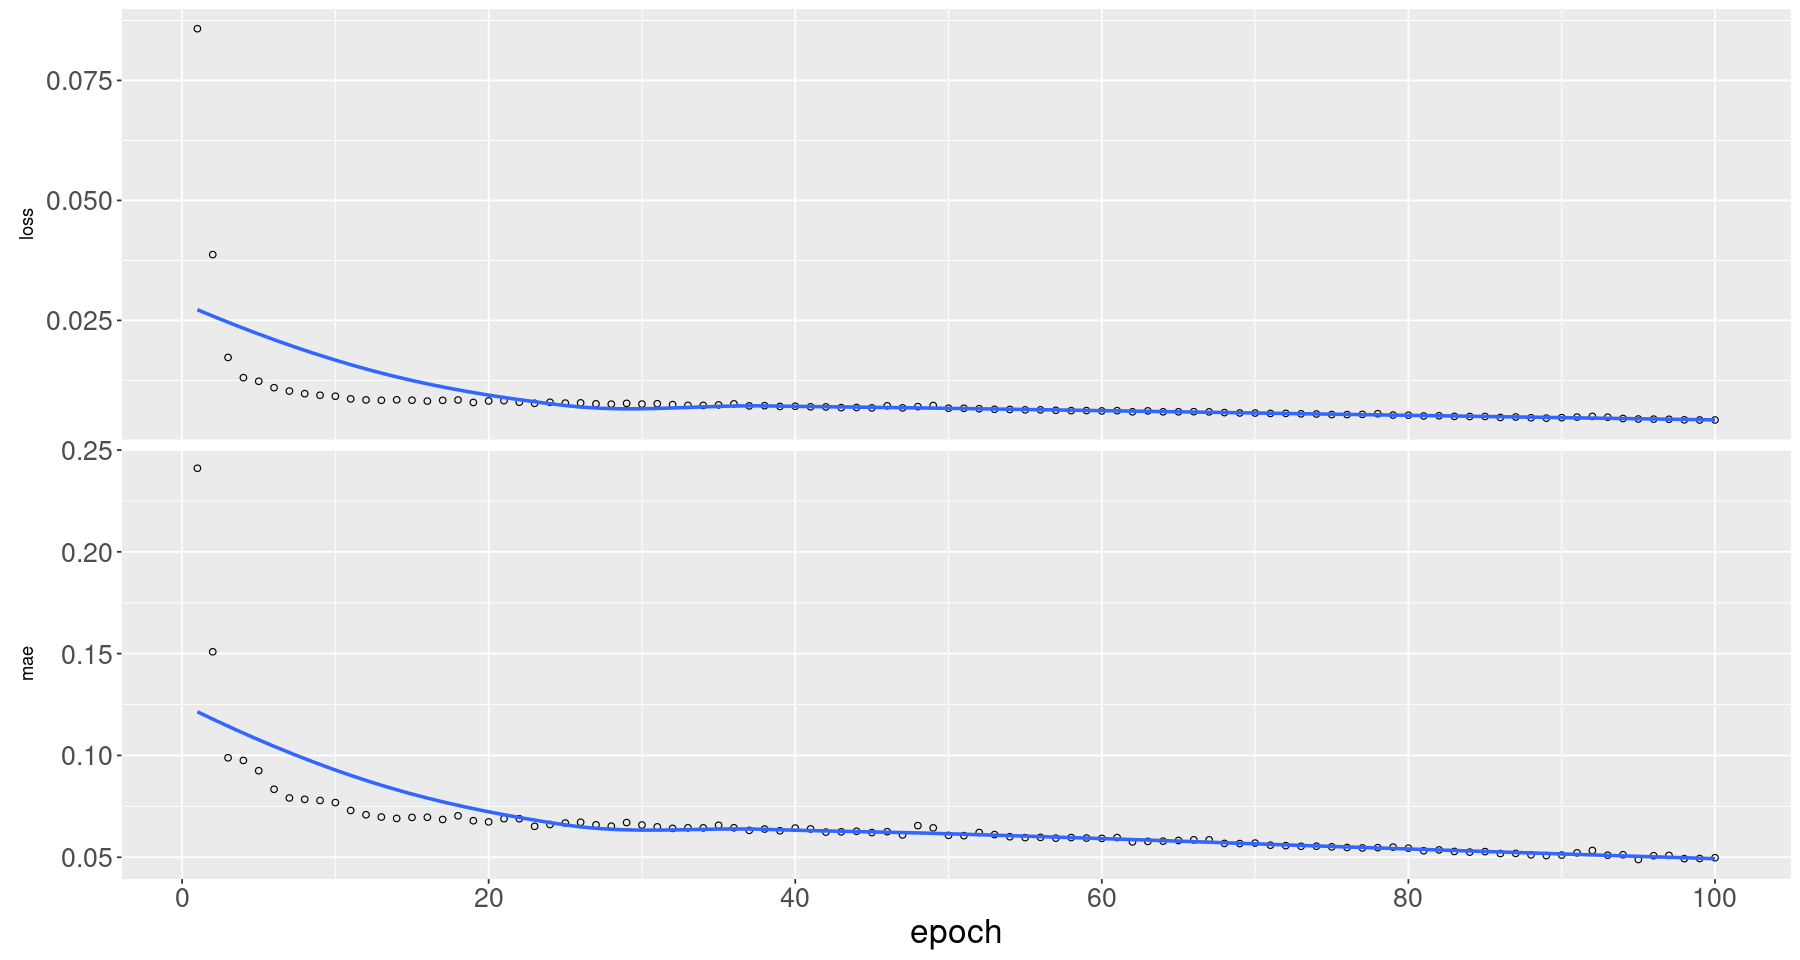

In [9]:
model <- keras_model_sequential()
model %>%
  layer_lstm(units = 50, input_shape = dim(x_train)[-1]) %>%
  layer_dense(units = 1)

model %>% compile(
  loss = "mse",
  optimizer= 'adam',
  metric = "mae" 
)

history <- model %>% 
 fit(x_train, y_train, epochs = 100, batch_size = 16, verbose = 2)

plot(history) + theme(text = element_text(size = 20)) 

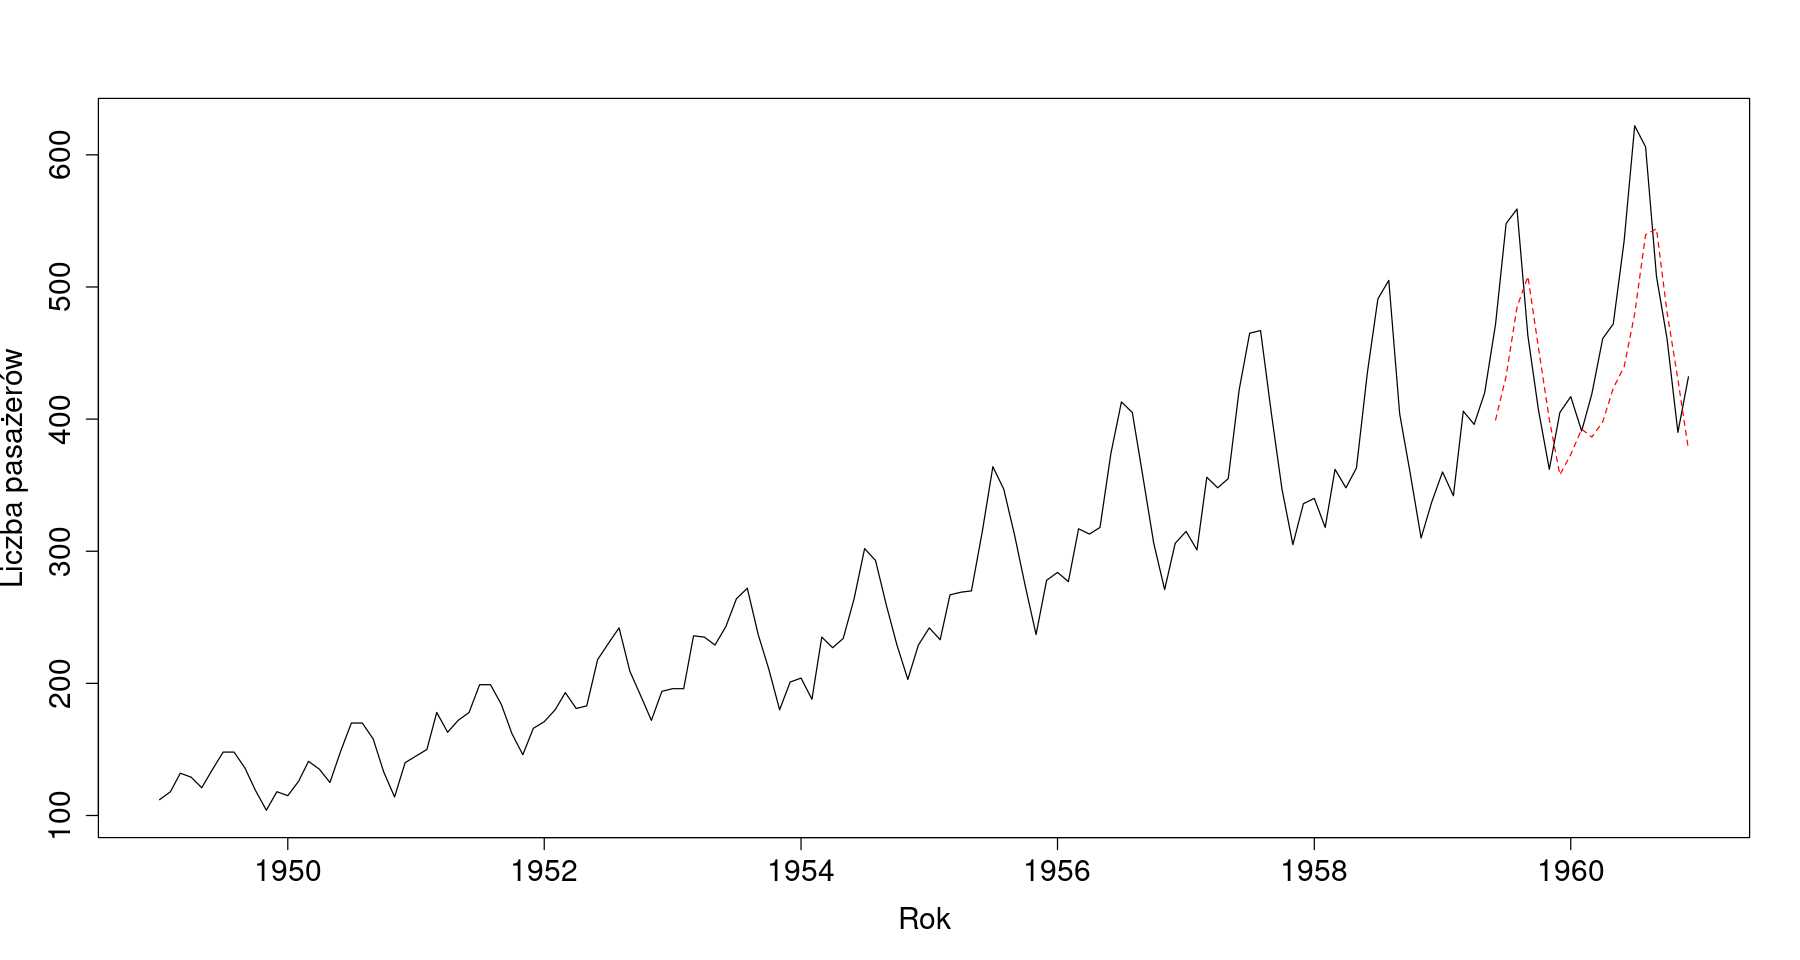

In [10]:
pred_lstm <- model %>% predict(x_test)

plot(x=data$month, y=denormalize(data$passengers, min_x, max_x), type="l", col='black', 
     xlab="Rok", ylab="Liczba pasażerów", cex.lab=1.5, cex.axis=1.5, cex.main=1.5, cex.sub=1.5)

lines(data[(nrow(data) - length(y_test)+1):nrow(data),'month'], 
      y=denormalize(pred_lstm, min_x, max_x), lty=2, col='red')

Możemy porównać powyższe trzy modele obliczając dla każdego z nich MAE dla zbioru testowego:

In [12]:
suppressPackageStartupMessages(library(Metrics))

sprintf("Perceptron: %.2f", mae(y_test, pred_nn))
sprintf("RNN: %.2f", mae(y_test, pred_rnn))
sprintf("LSTM: %.2f", mae(y_test, pred_lstm))

[1] "Perceptron: 0.31"

[1] "RNN: 0.09"

[1] "LSTM: 0.11"

Pomimo tego, że analizowany przykład jest bardzo prosty, widoczna jest przewaga bardziej złożonych modeli. Najmniejszy błąd uzyskała sieć RNN, jednakże należy pamiętać o problemie zanikającego gradientu w tej architekturze. W przedstawionym przykładzie nie jest to widoczne, ponieważ sekwencja wejściowa jest krótka $L=5$. Dla dłuższych sekwencji rozwiązaniem problemu zanikającego gradientu może być zastosowanie LSTM zamiast prostej sieci RNN.

## Przewidywanie wielu kroków w przód
Predykcję wielu kroków w przód dla serii czasowej można potraktować jako problem sequence-to-sequence. Dostarczając na wejście modelu sekwencję przeszłych zdarzeń, będziemy chcieli otrzymać na wyjściu przewidzianą sekwencję przyszłych zdarzeń. W tym celu użyjemy modelu **kodera-dekodera**.

Zadaniem **kodera** jest przetworzenie danych wejściowych, a następnie zwrócenie wektora o stałej długości będącego pewną reprezentacją wejścia. Jako kodera możemy użyć modelu RNN lub LSTM.

**Dekoder** ma za zadanie przetworzyć wektor otrzymany z kodera na sekwencję wyjściową, która będzie predykcją przyszłych zdarzeń w szeregu czasowym. Podobnie jak poprzednio, tutaj również możemy użyć jako dekodera model RNN lub LSTM.

Alternatywnym rozwiązaniem jest podejście **single-shot**, gdzie wszystkie kolejne kroki przewidywane są jednocześnie. Możemy tutaj zastosować takie same modele, jakie były wykorzystywane przy predykcji jednego kroku, modyfikując jedynie ostatnią warstwę wyjściową. Warstwa `dense` nie będzie miała już jednego neuronu, lecz tyle ile kroków chcemy przewidzieć. Kolejne neurony będą odpowiadały kolejnym krokom.

### Przygotowanie danych
W przypadku predykcji wielokrokowej dane wejściowe pozostaną bez zmian natomiast nie będzie predykowana już jedna wartość, lecz zwracany będzie wektor wartości o długości równej liczbie kroków.

Przykładowa minisekwencja, gdy chcemy przewidzieć 3 kroki do przodu:
$$
x = \begin{bmatrix}v_1 & v_2 & v_3 & ... & v_t\end{bmatrix} \qquad y = \begin{bmatrix}v_{t+1} & v_{t+2} & v_{t+3}\end{bmatrix}
$$

W dalszej części tutorialu przyjmiemy, że interesuje nas predykcja pięciu kroków do przodu, a długość miniserii przekazywanej na wejście algorytmu będzie wynosić 19.

In [32]:
splited_seq <- split_sequence(data_train, x_len = 19, y_len = 5)

x_train <- splited_seq$x
y_train <- splited_seq$y

splited_seq <- split_sequence(data_test, x_len = 19, y_len = 5)

x_test <- splited_seq$x
y_test <- splited_seq$y

### Encoder-decoder model

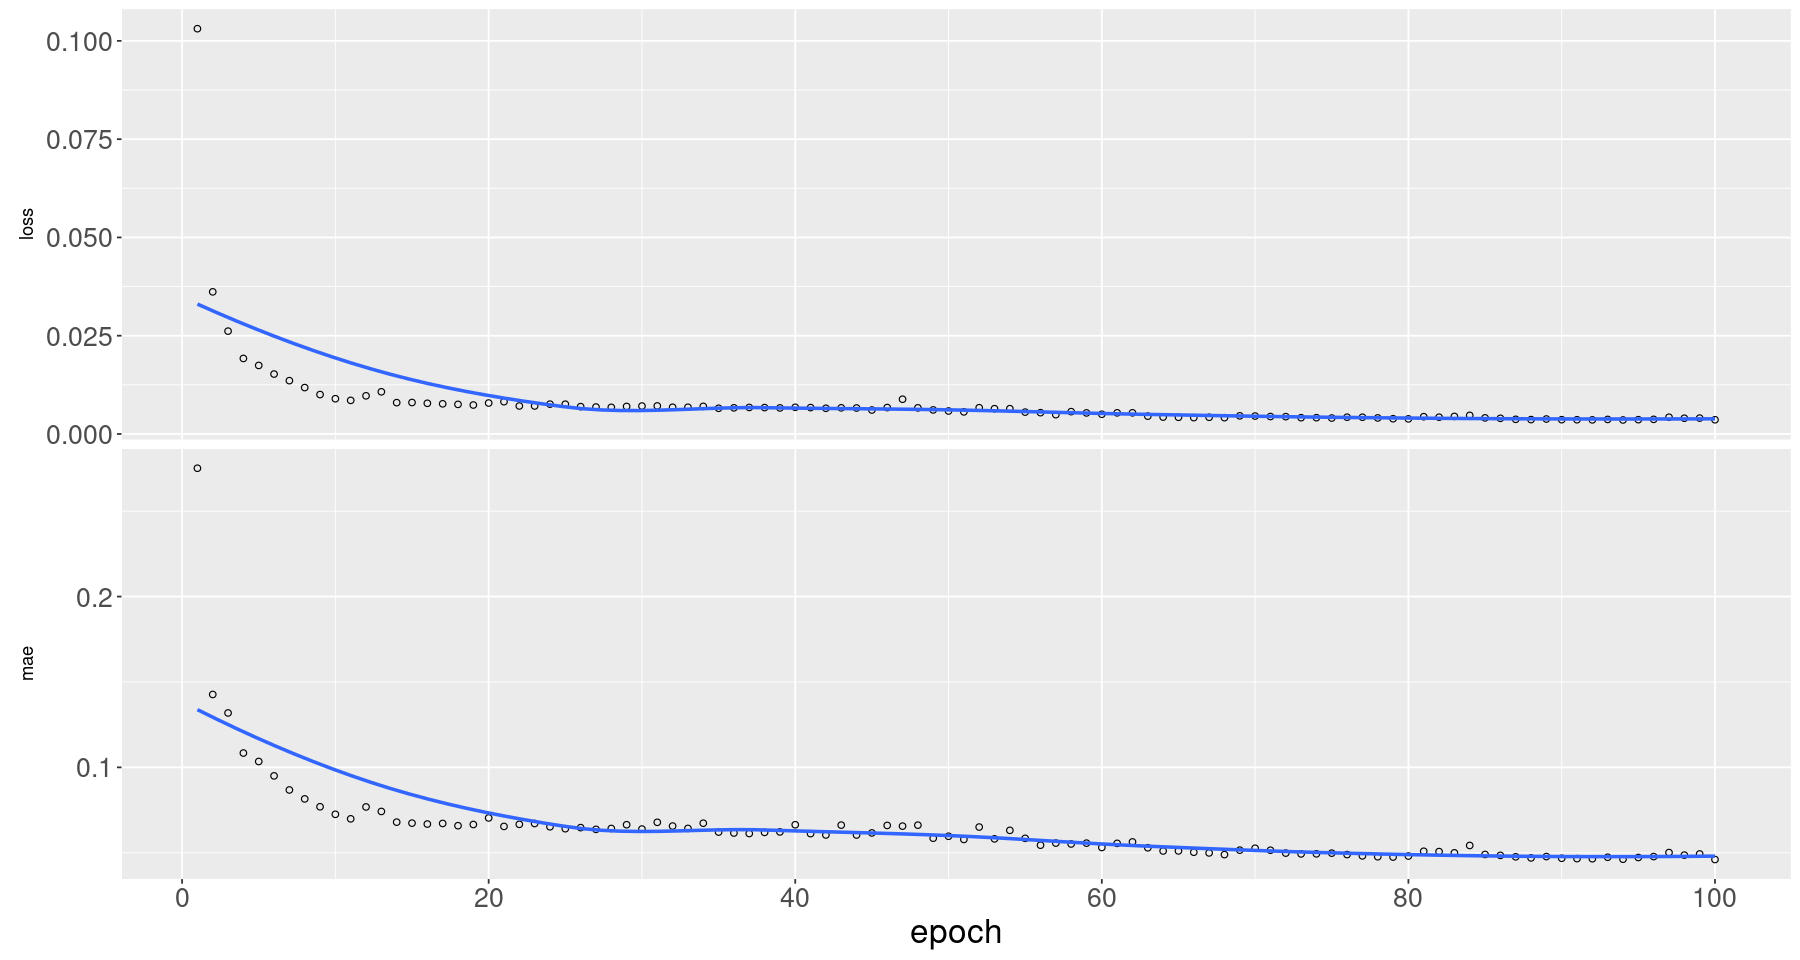

In [33]:
n_steps = 5

model <- keras_model_sequential()
model %>%
  layer_lstm(units = 50, input_shape = dim(x_train)[-1]) %>%
  layer_repeat_vector(n_steps) %>%
  layer_lstm(units = 50, return_sequences = TRUE) %>%
  time_distributed(layer_dense(units = 1))

model %>% compile(
  loss = "mse",
  optimizer= 'adam',
  metric = "mae" 
)

history <- model %>% 
 fit(x_train, y_train, epochs = 100, batch_size = 16, verbose = 2)

plot(history) + theme(text = element_text(size = 20)) 

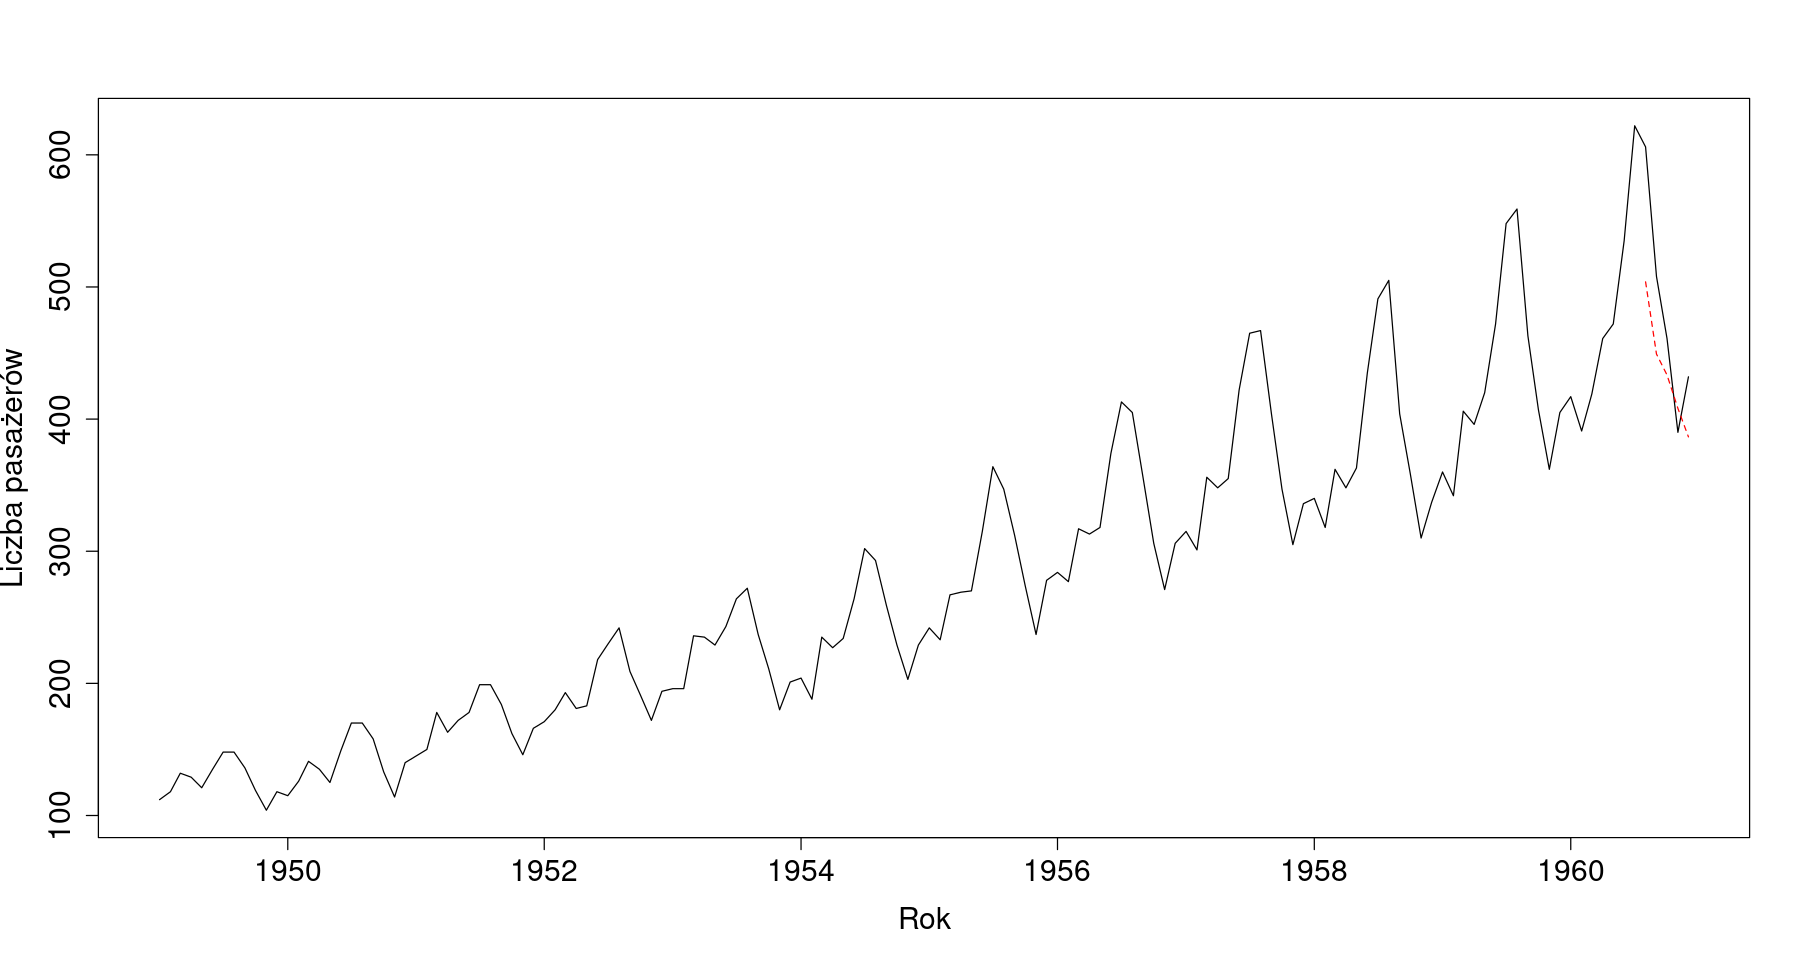

In [34]:
pred_enc_dec <- model %>% predict(array(x_test, c(1,19,1)))

plot(x = data$month, y = denormalize(data$passengers, min_x, max_x), type = "l", col = 'black', 
     xlab="Rok", ylab="Liczba pasażerów", cex.lab=1.5, cex.axis=1.5, cex.main=1.5, cex.sub=1.5)

lines(data[(nrow(data) - n_steps+1):nrow(data),'month'], 
      y=denormalize(pred_enc_dec, min_x, max_x), lty=2, col='red')

Obliczamy MAE:

In [35]:
mae(y_test, pred_enc_dec)

[1] 0.09732825

### Single-shot model

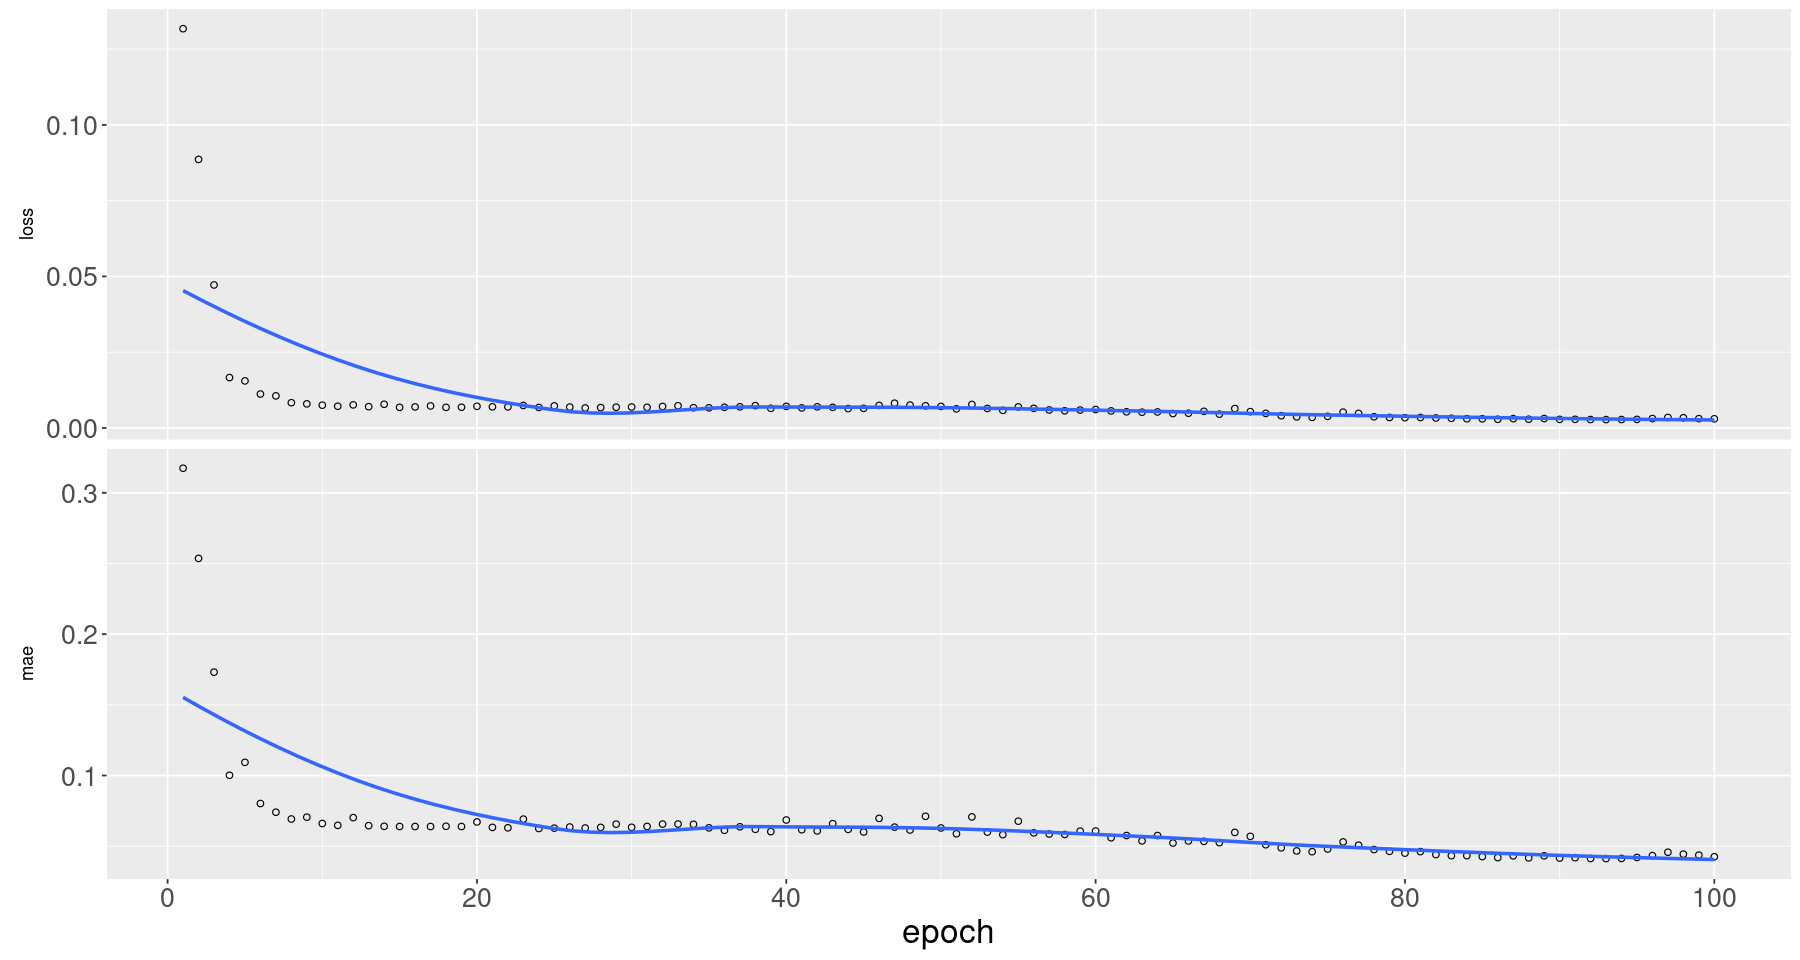

In [36]:
library(keras)

model <- keras_model_sequential()
model %>%
  layer_lstm(units = 50, input_shape = dim(x_train)[-1]) %>%
  layer_dense(units = 5)

model %>% compile(
  loss = "mse",
  optimizer= 'adam',
  metric = "mae" 
)

history <- model %>% 
 fit(x_train, y_train, epochs = 100, batch_size = 16, verbose = 2)

plot(history) + theme(text = element_text(size = 20)) 

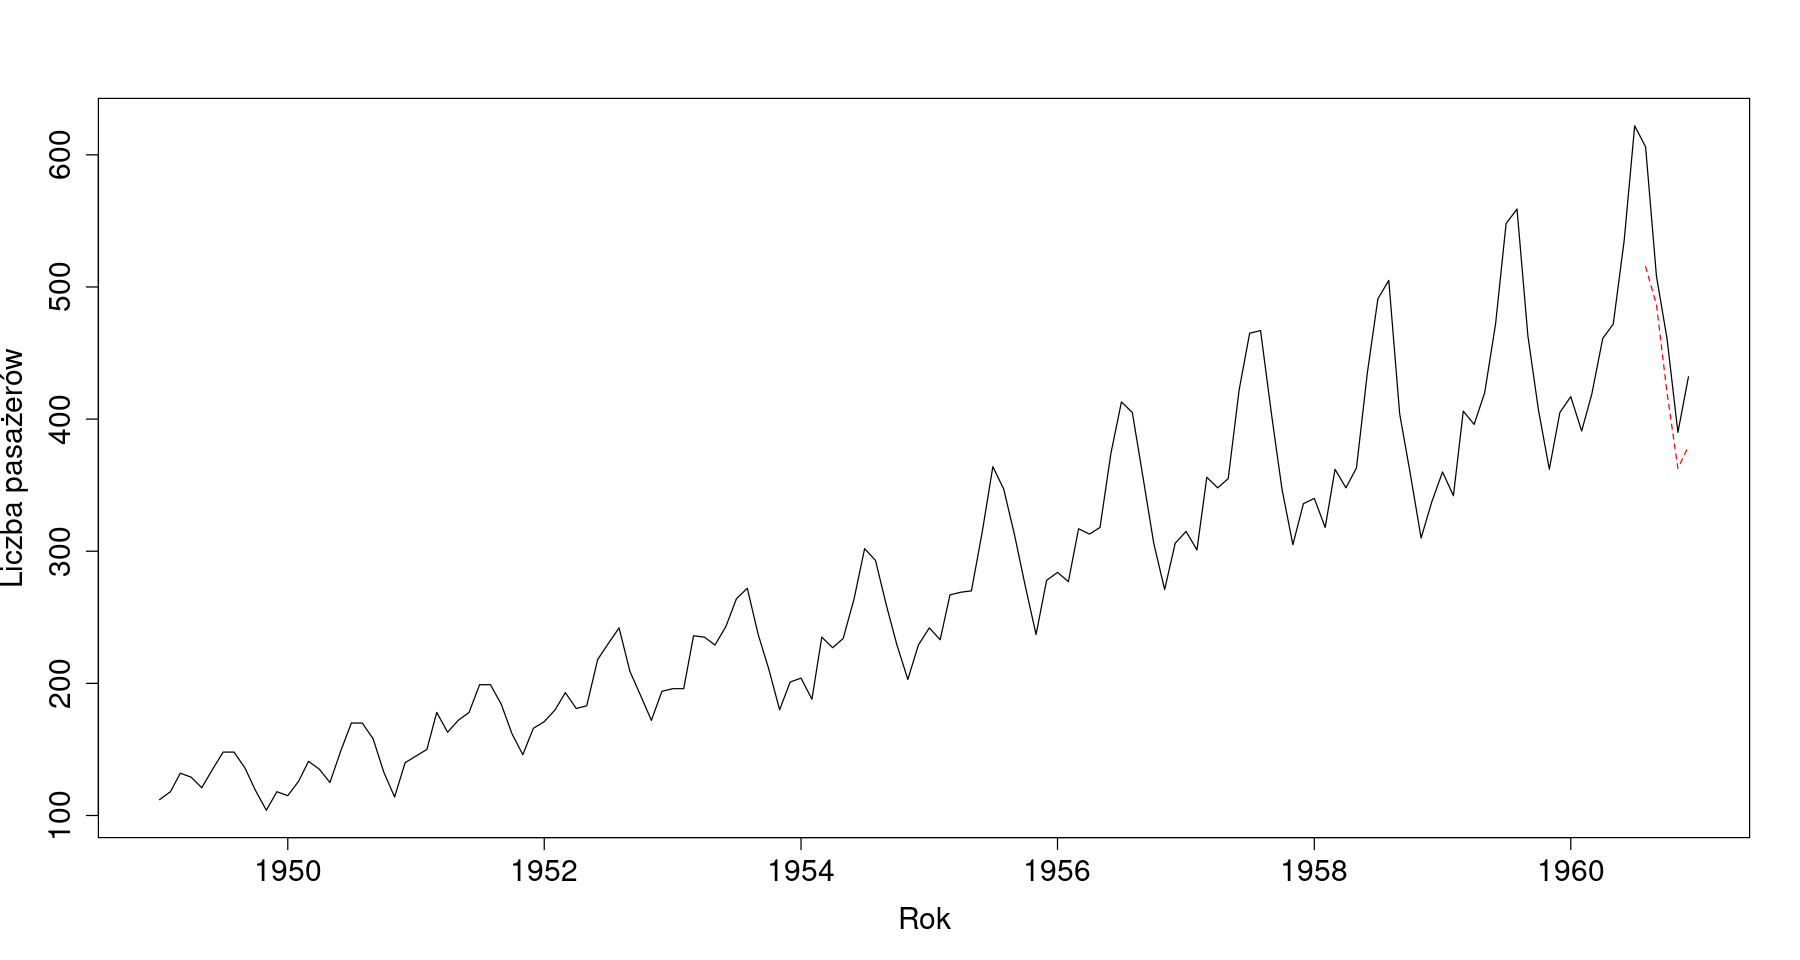

In [37]:
pred_enc_dec <- model %>% predict(array(x_test, c(1,19,1)))

plot(x = data$month, y = denormalize(data$passengers, min_x, max_x), type = "l", col = 'black', 
     xlab="Rok", ylab="Liczba pasażerów", cex.lab=1.5, cex.axis=1.5, cex.main=1.5, cex.sub=1.5)

lines(data[(nrow(data) - n_steps+1):nrow(data),'month'], 
      y=denormalize(pred_enc_dec, min_x, max_x), lty=2, col='red')

Obliczamy MAE:

In [38]:
mae(y_test, pred_enc_dec)

[1] 0.08989861

## Podsumowanie
W materiale zaprezentowano różne podejścia do predykcji szeregów czasowych za pomocą sieci neuronowych. Widoczne jest, że bardziej złożone, nieliniowe głębokie modele pozwalają uzyskać lepsze rezultaty w porównaniu do prostego perceptronu, który można traktować jako model AR. Niewątpliwą wadą podejścia wykorzystującego sieci neuronowe jest mniejsza interpretowalność modelu w porównaniu do klasycznych metod takich jak ARIMA.

Należy zaznaczyć, że zaprezentowane tutaj architektury sieci neuronowych są tylko niewielkim wycinkiem istniejących rozwiązań. Zainteresowane osoby powinny również zwrócić uwagę np. na:
- stacked LSTM
- bidirectional LSTM
- CNN LSTM
- ConvLSTM
- GRU
- Transformer-based LTSF models